# Summary

* Predicted **the gender associated with a Mandarin Chinese given name** using **state-of-the-art machine learning models for classification**, using **character frequencies** or **character embeddings**, and/or **phonotactic features** that correlate with gender as features.

* Evaluated the performance of the ML models.

* Achieved **~80% accuracy** using just character frequencies or character embeddings as the feature, and **~60% accuracy** using just the phonotactic features.

* Found that models' performance is **not imporved** when character frequencies or character embeddings **and phonotactic features** are used as features.

# Feature Engineering

* Skip this section by downloading and uploading **[Corpus_all_processed.csv](https://drive.google.com/file/d/1YGvPy3uB9_uzt51DQF0UZoTCm8K_M5dj/view?usp=sharing)** to colab.

* Otherwise, run the following code in this section.

* Download and upload **[charfreq.csv](https://drive.google.com/file/d/1HdE2wJFJpj3oZsbJBUwlSzEjzT2N0h3u/view?usp=sharing)** and **[Corpus_processed.csv](https://drive.google.com/file/d/1zZVXsMYruF2-AWFJZUSAj_6SB0ir-zQx/view?usp=sharing)** to colab.

* Load character frequencies dictionary.

In [ ]:
charfreq = {} #char: male_proportion

with open('charfreq.csv', 'r') as f: # https://github.com/observerss/ngender/blob/master/ngender/charfreq.csv
    f.readline() # skip header
    for line in f.readlines():
        char, male, female = line.strip().split(',')
        charfreq[char] = float(male)/(float(male)+float(female))

* Load pretrained FastText Chinese word embeddings.

In [ ]:
!pip install fasttext
import fasttext
import fasttext.util

In [ ]:
fasttext.util.download_model('zh', if_exists='ignore')  # zh = Chinese
ft = fasttext.load_model('cc.zh.300.bin')

In [ ]:
ft.get_word_vector("丽") # beauty; common character in female names

In [ ]:
ft.get_nearest_neighbors("玲") # tinkling sound; common character in female names

[(0.4969545304775238, '琪'),
 (0.4905205965042114, '莉'),
 (0.48493680357933044, '雯'),
 (0.4841586947441101, '芊'),
 (0.4825659692287445, '璇'),
 (0.4777986407279968, '姗'),
 (0.4705442488193512, '娟'),
 (0.47040659189224243, '小玲'),
 (0.4680013656616211, '琪琪'),
 (0.46487537026405334, '彤')]

In [ ]:
ft.get_nearest_neighbors("伟") # great; common character in male names

[(0.4791296422481537, '伟是'),
 (0.4639599919319153, '志远'),
 (0.4574549198150635, '奋'),
 (0.44498583674430847, '华琳'),
 (0.444376677274704, '的伟'),
 (0.443287193775177, '庆红'),
 (0.435908704996109, '康伟'),
 (0.43396663665771484, '董维'),
 (0.4319266974925995, '由伟'),
 (0.43135979771614075, '福财')]

* Alternatively, can use spacy's word vectors

In [ ]:
!pip install -U spacy
!python -m spacy download zh_core_web_lg # https://spacy.io/models/zh

import zh_core_web_lg
nlp = zh_core_web_lg.load()

In [4]:
import numpy as np

In [14]:
target = "玲"

ms = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[target]]]), n = 10)

words = [nlp.vocab.strings[w] for w in ms[0][0]]
distances = ms[2]

print(words, distances)

['玲', '娟', '玲av', '霞', '珊', '琦', '萍', '莉', '彦', '芳'] [[1.     0.6391 0.6077 0.5519 0.5514 0.5396 0.5379 0.522  0.5079 0.5054]]


In [15]:
target = "伟"

ms = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[target]]]), n = 10)

words = [nlp.vocab.strings[w] for w in ms[0][0]]
distances = ms[2]

print(words, distances)

['伟', '毅', '斌', '彬', '辉', '勇', '俊', '炜', '欣', '祥'] [[1.     0.6873 0.6757 0.6322 0.6242 0.6222 0.6199 0.6078 0.5841 0.5793]]


* Add character frequencies and character embeddings columns to corpus. 

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("Corpus_processed.csv") 

In [ ]:
df['Given1_freq'] = df.apply(lambda row: charfreq.setdefault(row['Given1'], 0.5), axis=1)
df['Given2_freq'] = df.apply(lambda row: charfreq.setdefault(row['Given2'], 0.5), axis=1)

In [ ]:
df['Given1_vec'] = df.apply(lambda row: ft.get_word_vector(row['Given1']), axis = 1)
df['Given2_vec'] = df.apply(lambda row: ft.get_word_vector(row['Given2']), axis = 1)

In [ ]:
import numpy as np

In [ ]:
df['embeddings'] = df.apply(lambda row: np.concatenate((row['Given1_vec'], row['Given2_vec'])), axis = 1)

* Add two more columns to corpus.

In [ ]:
df['1_open_syll_p'] = 1 - df['open_syll_p']
df['1_hi_nuc_p'] = 1 - df['hi_nuc_p']

* Save processed corpus.

In [ ]:
df.to_csv('Corpus_all_processed.csv')

# Load Processed Corpus

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Corpus_all_processed.csv')

In [ ]:
# Convert embeddings stored as strings to lists of floats
df['embeddings'] = df.apply(lambda row: [float(s) for s in row['embeddings'][1:-1].split()], axis = 1)

# Features

In [ ]:
# Just character frequencies
X = df[['Given1_freq', 'Given2_freq']].values

In [ ]:
# Just character embeddings
X = df['embeddings'].values.tolist()

In [ ]:
# Just phonotactic features 
X = df[['1_open_syll_p', '1_hi_nuc_p', 'bk_nuc_p', 'rd_nuc_p', 'obsr_ons_p', 'non_cor_ons_p']].values

In [ ]:
# Character frequencies and phonotactic features
X = df[['Given1_freq', 'Given2_freq', '1_open_syll_p', '1_hi_nuc_p', 'bk_nuc_p', 'rd_nuc_p', 'obsr_ons_p', 'non_cor_ons_p']].values

In [ ]:
# Character embeddings and phonotaictic features
X = df[['embeddings', '1_open_syll_p', '1_hi_nuc_p', 'bk_nuc_p', 'rd_nuc_p', 'obsr_ons_p', 'non_cor_ons_p']].values

import numpy as np
X = [np.concatenate((row[0], row[1:])) for row in X]
X = [[float(num) for num in row] for row in X]

# Label

In [ ]:
y = df['Gender'].values

# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100, stratify = y)

# Helper Functions  ...
... to evaluate the performance of ML models

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred)))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

In [ ]:
def visualize_performance(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.show()

# State-of-the-Art Machine Learning Models

## Naive Bayes Classifier

F1 score: 0.828696
AUC score: 0.823003


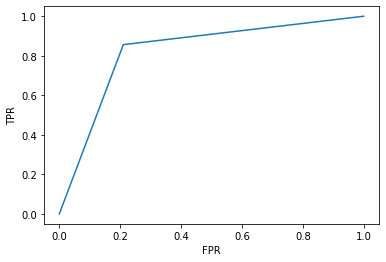

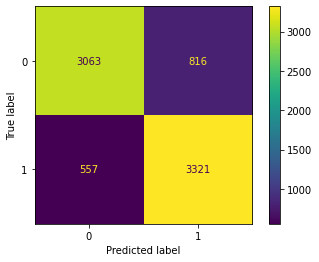

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
print_scores(lr, X_train, y_train, X_test, y_test)
visualize_performance(lr, X_test, y_test)

## Logistic Regression

F1 score: 0.828696
AUC score: 0.823003


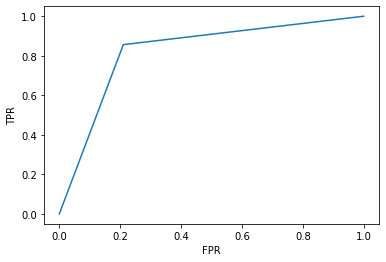

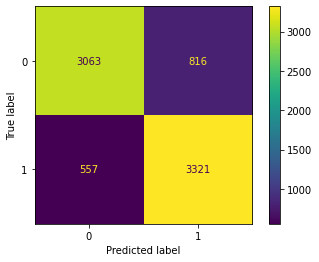

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
print_scores(lr, X_train, y_train, X_test, y_test)
visualize_performance(lr, X_test, y_test)

## Ridge Classifier

F1 score: 0.830653
AUC score: 0.820815


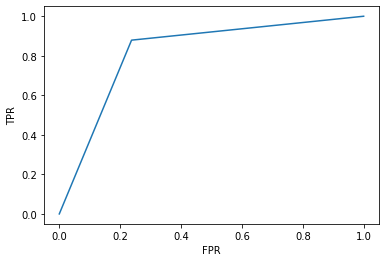

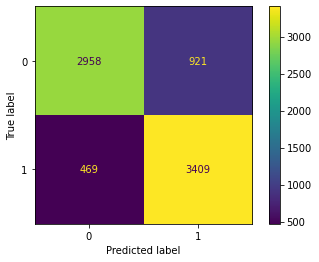

In [ ]:
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier()
print_scores(rc, X_train, y_train, X_test, y_test)
visualize_performance(rc, X_test, y_test)

## Support Vector Classifier

F1 score: 0.831710
AUC score: 0.821846


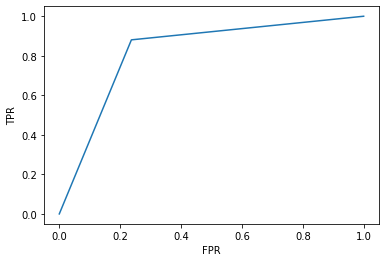

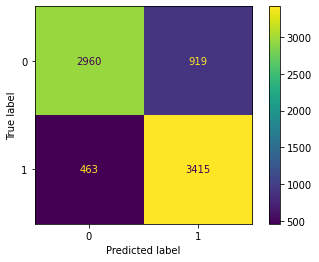

In [ ]:
from sklearn.svm import SVC
svc = SVC()
print_scores(svc, X_train, y_train, X_test, y_test)
visualize_performance(svc, X_test, y_test)

## Linear SVC

F1 score: 0.829032
AUC score: 0.822359


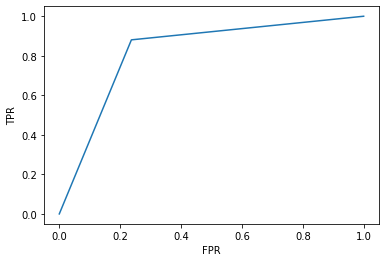

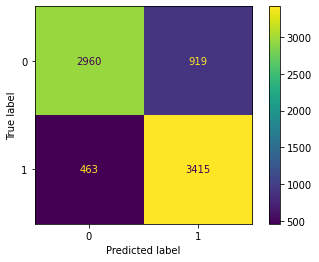

In [ ]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
print_scores(lsvc, X_train, y_train, X_test, y_test)
visualize_performance(svc, X_test, y_test)

## K Neighbors Classifier

F1 score: 0.813234
AUC score: 0.809336


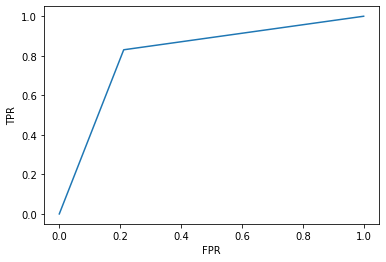

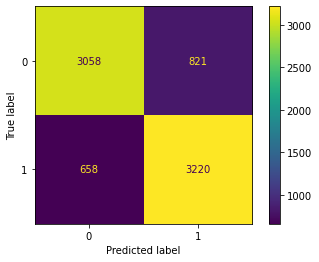

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
print_scores(knn, X_train, y_train, X_test, y_test)
visualize_performance(knn, X_test, y_test)

## Decision Tree Classifier

F1 score: 0.756515
AUC score: 0.761503


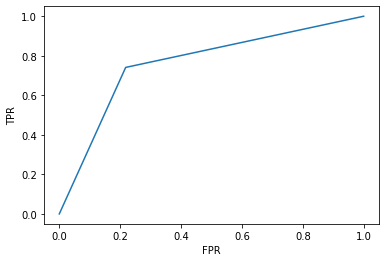

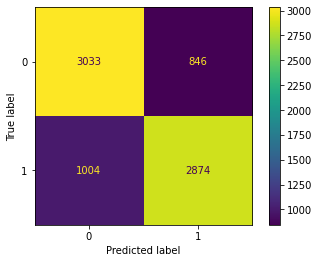

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
print_scores(dtc, X_train, y_train, X_test, y_test)
visualize_performance(dtc, X_test, y_test)

## Random Forest Classifier

F1 score: 0.797504
AUC score: 0.795025


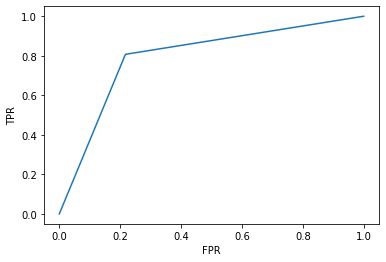

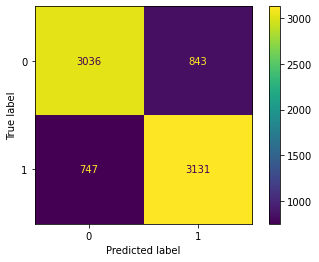

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
print_scores(rf, X_train, y_train, X_test, y_test)
visualize_performance(rf, X_test, y_test)

## Multi-Layer Perceptron Classifier

F1 score: 0.828162
AUC score: 0.822230


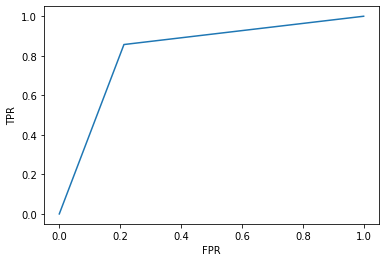

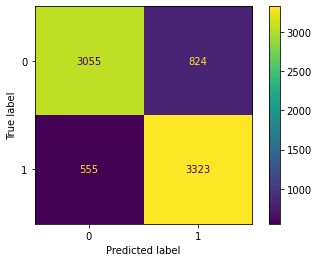

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
print_scores(mlp, X_train, y_train, X_test, y_test)
visualize_performance(mlp, X_test, y_test)